##### Title: Exercice 11.2
##### Author: Jerock Kalala
##### Date: Febuary 28th 2023
##### Modified By: --
##### Exercise: Sentiment Analysis


Load up Dependencies

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
#import text_normalizer as tn

Check if GPU is available for use!

In [3]:
tf.compat.v1.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
tf.compat.v1.test.gpu_device_name()

''

### Load and view Dataset

In [5]:
dataset = pd.read_csv("E:\\Bellevue\\Winter_2022\\DSC 360 Data Mining Text Analytics an\\Week_10\\hotel-reviews.csv", encoding='ISO-8859-1')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       38932 non-null  object
 1   Description   38932 non-null  object
 2   Browser_Used  38932 non-null  object
 3   Device_Used   38932 non-null  object
 4   Is_Response   38932 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [6]:
dataset.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [7]:
#keep necessary data
dataset.drop(columns = ['User_ID', 'Browser_Used', 'Device_Used'], inplace = True)

In [8]:
dataset['Is_Response'] = [1 if Is_Response == 'happy' else 0 for Is_Response in dataset['Is_Response'].values]
dataset.head()

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,0
1,I stayed at the Crown Plaza April -- - April -...,0
2,I booked this hotel through Hotwire at the low...,0
3,Stayed here with husband and sons on the way t...,1
4,My girlfriends and I stayed here to celebrate ...,0


### Build train, validation and test datasets

In [9]:
description = dataset['Description'].values
response = dataset['Is_Response'].values

train_description = description[:30000]
train_response = response[:30000]

val_description = description[30000:35000]
val_response = response[30000:35000]

test_description = description[35000:]
test_response = response[35000:]
train_description.shape, val_description.shape, test_description.shape

((30000,), (5000,), (3932,))

### Basic Text Wrangling

In [10]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#def expand_contractions(text):
#    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

#cleaning function
def pre_process_document(document):

    # strip HTML
    document = strip_html_tags(document)

    # lower case
    document = document.lower()

    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))

    # remove accented characters
    document = remove_accented_chars(document)

    # expand contractions
#    document = expand_contractions(document)

    # remove special characters and\or digits
    # insert spaces between special characters to isolate them
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)

    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()

    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [11]:
train_description = pre_process_corpus(train_description)
val_description = pre_process_corpus(val_description)
test_description = pre_process_corpus(test_description)

C:\Users\jeroc\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


### Build Data Ingestion Functions

In [12]:
# Training input on the whole training set with no limit on training epochs.
#train_input_fn = tf.estimator.inputs.numpy_input_fn({'sentence': train_description}, train_response,
#    batch_size=256, num_epochs=None, shuffle=True)

train_input_fn =tf.compat.v1.estimator.inputs.numpy_input_fn({'sentence': train_description}, train_response,
    batch_size=256, num_epochs=None, shuffle=True)

In [13]:
# Prediction on the whole training set.
predict_train_input_fn =tf.compat.v1.estimator.inputs.numpy_input_fn({'sentence': train_description}, train_response,
     shuffle=False)

In [14]:
# Prediction on the whole validation set.
predict_val_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': val_description}, val_response, shuffle=False)

In [15]:
# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': test_description}, test_response, shuffle=False)

### Build Deep Learning Model with Universal Sentence Encoder

In [16]:
embedding_feature = hub.text_embedding_column(
    key='sentence',
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [17]:
dnn = tf.compat.v1.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.compat.v1.nn.relu,
          dropout=0.1,
          optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.005))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\jeroc\\AppData\\Local\\Temp\\tmpisy5sx9y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\jeroc\\AppData\\Local\\Temp\\tmpisy5sx9y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


- Train for approx 12 epochs

In [18]:
256*1500/3000

128.0

### Model Training

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import time

TOTAL_STEPS = 1500
STEP_SIZE = 100
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 139.35413432121277
Eval Metrics (Train): {'accuracy': 1.0, 'accuracy_baseline': 1.0, 'auc': 0.99999994, 'auc_precision_recall': 0.0, 'average_loss': 0.00037796018, 'label/mean': 0.0, 'loss': 0.048250236, 'precision': 0.0, 'prediction/mean': 0.00037712054, 'recall': 0.0, 'global_step': 100}
Eval Metrics (Validation): {'accuracy': 1.0, 'accuracy_baseline': 1.0, 'auc': 1.0, 'auc_precision_recall': 0.0, 'average_loss': 0.00037912192, 'label/mean': 0.0, 'loss': 0.04739024, 'precision': 0.0, 'prediction/mean': 0.00037838364, 'recall': 0.0, 'global_step': 100}

----------------------------------------------------------------------------------------------------
Training for step = 100
Train Time (s): 75.42655634880066
Eval Metrics (Train): {'accuracy': 1.0, 'accuracy_baseline': 1.0, 'auc': 0.99999994, 'auc_precision_recall': 0.0, 'average_loss': 0.00016688

### Model Evaluation

In [19]:
dnn.evaluate(input_fn=predict_train_input_fn)

INFO:tensorflow:Could not find trained model in model_dir: C:\Users\jeroc\AppData\Local\Temp\tmpisy5sx9y, running initialization to evaluate.


INFO:tensorflow:Could not find trained model in model_dir: C:\Users\jeroc\AppData\Local\Temp\tmpisy5sx9y, running initialization to evaluate.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.


Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2023-03-02T22:51:27


INFO:tensorflow:Starting evaluation at 2023-03-02T22:51:27


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Inference Time : 46.66022s


INFO:tensorflow:Inference Time : 46.66022s


INFO:tensorflow:Finished evaluation at 2023-03-02-22:52:14


INFO:tensorflow:Finished evaluation at 2023-03-02-22:52:14


INFO:tensorflow:Saving dict for global step 0: accuracy = 0.6287, accuracy_baseline = 0.6824667, auc = 0.44414762, auc_precision_recall = 0.6342907, average_loss = 0.6895257, global_step = 0, label/mean = 0.6824667, loss = 88.02456, precision = 0.677128, prediction/mean = 0.5065047, recall = 0.87149554


INFO:tensorflow:Saving dict for global step 0: accuracy = 0.6287, accuracy_baseline = 0.6824667, auc = 0.44414762, auc_precision_recall = 0.6342907, average_loss = 0.6895257, global_step = 0, label/mean = 0.6824667, loss = 88.02456, precision = 0.677128, prediction/mean = 0.5065047, recall = 0.87149554


{'accuracy': 0.6287,
 'accuracy_baseline': 0.6824667,
 'auc': 0.44414762,
 'auc_precision_recall': 0.6342907,
 'average_loss': 0.6895257,
 'label/mean': 0.6824667,
 'loss': 88.02456,
 'precision': 0.677128,
 'prediction/mean': 0.5065047,
 'recall': 0.87149554,
 'global_step': 0}

In [20]:
dnn.evaluate(input_fn=predict_test_input_fn)

INFO:tensorflow:Could not find trained model in model_dir: C:\Users\jeroc\AppData\Local\Temp\tmpisy5sx9y, running initialization to evaluate.


INFO:tensorflow:Could not find trained model in model_dir: C:\Users\jeroc\AppData\Local\Temp\tmpisy5sx9y, running initialization to evaluate.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2023-03-02T22:52:22


INFO:tensorflow:Starting evaluation at 2023-03-02T22:52:22


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 17.22255s


INFO:tensorflow:Inference Time : 17.22255s


INFO:tensorflow:Finished evaluation at 2023-03-02-22:52:39


INFO:tensorflow:Finished evaluation at 2023-03-02-22:52:39


INFO:tensorflow:Saving dict for global step 0: accuracy = 0.60274667, accuracy_baseline = 0.68209565, auc = 0.41171944, auc_precision_recall = 0.6065924, average_loss = 0.6911097, global_step = 0, label/mean = 0.68209565, loss = 87.65946, precision = 0.6687764, prediction/mean = 0.50494164, recall = 0.82736766


INFO:tensorflow:Saving dict for global step 0: accuracy = 0.60274667, accuracy_baseline = 0.68209565, auc = 0.41171944, auc_precision_recall = 0.6065924, average_loss = 0.6911097, global_step = 0, label/mean = 0.68209565, loss = 87.65946, precision = 0.6687764, prediction/mean = 0.50494164, recall = 0.82736766


{'accuracy': 0.60274667,
 'accuracy_baseline': 0.68209565,
 'auc': 0.41171944,
 'auc_precision_recall': 0.6065924,
 'average_loss': 0.6911097,
 'label/mean': 0.68209565,
 'loss': 87.65946,
 'precision': 0.6687764,
 'prediction/mean': 0.50494164,
 'recall': 0.82736766,
 'global_step': 0}

### Build a Generic Model Trainer on any Input Sentence Encoder

In [21]:
import time

TOTAL_STEPS = 1500
STEP_SIZE = 500

my_checkpointing_config = tf.compat.v1.estimator.RunConfig(
    keep_checkpoint_max = 2,       # Retain the 2 most recent checkpoints.
)

def train_and_evaluate_with_sentence_encoder(hub_module, train_module=False, path=''):
    embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec=hub_module, trainable=train_module)

    print()
    print('='*100)
    print('Training with', hub_module)
    print('Trainable is:', train_module)
    print('='*100)

    dnn = tf.compat.v1.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.compat.v1.nn.relu,
            dropout=0.1,
            optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=path,
            config=my_checkpointing_config)

    for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
        print('-'*100)
        print('Training for step =', step)
        start_time = time.time()
        dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        elapsed_time = time.time() - start_time
        print('Train Time (s):', elapsed_time)
        print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
        print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

    train_eval_result = dnn.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = dnn.evaluate(input_fn=predict_test_input_fn)

    return {
      "Model Dir": dnn.model_dir,
      "Training Accuracy": train_eval_result["accuracy"],
      "Test Accuracy": test_eval_result["accuracy"],
      "Training AUC": train_eval_result["auc"],
      "Test AUC": test_eval_result["auc"],
      "Training Precision": train_eval_result["precision"],
      "Test Precision": test_eval_result["precision"],
      "Training Recall": train_eval_result["recall"],
      "Test Recall": test_eval_result["recall"]
    }

### Train Deep Learning Models on difference Sentence Encoders

- NNLM - pre-trained and fine-tuning
- USE - pre-trained and fine-tuning

In [22]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

results = {}

results["nnlm-en-dim128"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", path='.\\storage\\models\\nnlm-en-dim128_f\\')

results["nnlm-en-dim128-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", train_module=True, path='.\\storage\\models\\nnlm-en-dim128_t\\')

results["use-512"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", path='.\\storage\\models\\use-512_f\\')

results["use-512-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", train_module=True, path='.\\storage\\models\\use-512_t\\')


Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: False
----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 30.946471691131592
Eval Metrics (Train): {'accuracy': 0.8548333, 'accuracy_baseline': 0.6824667, 'auc': 0.9203631, 'auc_precision_recall': 0.9586054, 'average_loss': 0.32905224, 'label/mean': 0.6824667, 'loss': 42.006668, 'precision': 0.8836578, 'prediction/mean': 0.6712664, 'recall': 0.9066621, 'global_step': 500}
Eval Metrics (Validation): {'accuracy': 0.8508, 'accuracy_baseline': 0.673, 'auc': 0.914762, 'auc_precision_recall': 0.9519834, 'average_loss': 0.3416108, 'label/mean': 0.673, 'loss': 42.701347, 'precision': 0.87814033, 'prediction/mean': 0.6638266, 'recall': 0.9037147, 'global_step': 500}
----------------------------------------------------------------------------------------------------
Training for step = 500
Train Time (s): 17.01788592338562
Eval Metrics (Tra

### Model Evaluations

In [23]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,Model Dir,Training Accuracy,Test Accuracy,Training AUC,Test AUC,Training Precision,Test Precision,Training Recall,Test Recall
nnlm-en-dim128,.\storage\models\nnlm-en-dim128_f\,0.865667,0.851729,0.930530,0.915734,0.885358,0.880667,0.922634,0.905295
nnlm-en-dim128-with-training,.\storage\models\nnlm-en-dim128_t\,0.981033,0.880214,0.994986,0.927299,0.982920,0.904501,0.989401,0.921700
use-512,.\storage\models\use-512_f\,0.873700,0.859868,0.934748,0.924206,0.895173,0.889580,0.923024,0.907159
use-512-with-training,.\storage\models\use-512_t\,0.999967,0.890132,1.000000,0.895005,1.000000,0.918216,0.999951,0.920955


In [24]:
best_model_dir = results_df[results_df['Test Accuracy'] == results_df['Test Accuracy'].max()]['Model Dir'].values[0]
best_model_dir

'.\\storage\\models\\use-512_t\\'

In [27]:
embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec="https://tfhub.dev/google/universal-sentence-encoder/2", trainable=True)

dnn = tf.compat.v1.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=best_model_dir)
dnn

In [28]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

In [29]:
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

[1, 0, 0, 1, 1, 1, 0, 0, 1, 1]

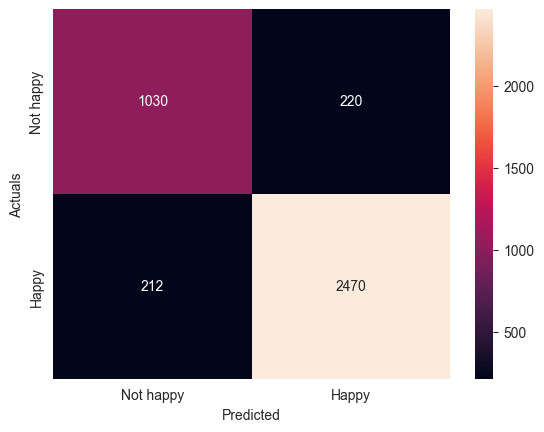

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.compat.v1.Session() as session:
    cm = tf.compat.v1.confusion_matrix(test_response, predictions).eval()

LABELS = ['Not happy', 'Happy']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")